The model is the model Xception from keras, pretrained in the imagenet competition.
This leads to a better initiation of weights, and had already learned the extraction 
of features from some ships.

To prevent the overfitting, there are:
    - Data augmentation
    - The model Xception has batch normalization
    - Save model with best validation accuracy
    - Use global averaging instead of a dense which is sensible to overfitting

There is also data augmentation in validation to improve the amount of sample in the validation set (4059 * 3), so
the best validation accuracy should give a good accuracy in the testing set.

One callback has been added to save the best validation accuracy. 

The model reduces the vanishing gradient by the implementation:
   - Skip connection
   - Use relu as activation function

I choose Xception neural network because:
  - It gives better scores than the other.
  - The model has one of the best accuracy in Imagenet and less parameters than the others (20M). This makes
    the neural network easier to train than Inception resnet v2 or NASNetLarge model.
  - In the paper it is stated that "Xception shows small gains in classification
    performance on the ImageNet dataset and large gains on the JFT dataset" meaning
    that the model is a good model for a general classification task. Maybe the others 
    models are adapt for input shape greater than (128, 192, 3)
    
The optimizer use is Adam, with a low learning rate set to 1e-4 because the 
weight has already be trained in imagenet, the optimizer will keep lowering the learning rate.
After 3 training sessions, the learning rate is set to 1e-5.
    
After 30 epochs, the model achieves 95.54% accuracy in the testing set.

After 60 epochs, the model achieves 95.8% accuracy in the testing set.

After 90 epochs, the model achieves 96.18% accuracy in the testing set.

After 120 epochs, the model achieves 96.99% accuracy in the testing set.

The weights '../input/xception/clement_fang_Xception.h5' gives an accuracy of 0.9687% in the test 
and around 97.7% in the validation set.

Every 30 epochs, I helped the neural network to train by loading the best validation accuracy 
in the 30 epochs previous epochs, and restarted a training session (3 times). 

For training from scratch, comment the load_weight in the second cell, change the default learning rate to 1e-4
in the fit_generator change the value of variable nb_training to 5 and epochs to 35

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from keras.models import load_model
from keras import backend as K
import gc

Using TensorFlow backend.


In [2]:
from keras.applications import Xception
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

input_shape = (128, 192, 3)

model = Xception(include_top=False, weights='imagenet', input_tensor=None, 
                 input_shape=input_shape, pooling='avg', classes=10)

input = Input(shape=input_shape)
t = model(input)
o = Dense(10, activation='softmax')(t)

model = Model(inputs=input, outputs=o)

model.load_weights('../input/xception/clement_fang_Xception.h5') # comment it if training from zero

model.compile(optimizer = Adam(lr = 1e-5), # if load weights 1e-5 else 1e-4
        loss='categorical_crossentropy',
        metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 1s 0us/step


In [3]:
from keras.callbacks import ModelCheckpoint
weight_path = 'network.hdf5'
model_checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', save_best_only=True, verbose=True, save_weights_only=True)

In [4]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 128
input_size = (128, 192)

train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            shear_range=0.2,
            zoom_range=0.2,
            validation_split=0.1,
            horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
            directory="../input/training-ships/ships_train2/ships_train",
            target_size=input_size,
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            subset = "training",
            shuffle=True)

val_generator = train_datagen.flow_from_directory(
            directory="../input/training-ships/ships_train2/ships_train",
            target_size=input_size,
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            subset = "validation",
            shuffle=False)

Found 36568 images belonging to 10 classes.
Found 4059 images belonging to 10 classes.


In [5]:
from keras.utils import np_utils

def compute_score(res, Y_test):
    s = 0
    for i in range (len(res)):
        if res[i] == Y_test[i]:
            s += 1
    return s / (len(res))

ships = np.load('../input/reco-nav-2/ships_test.npz')
X_test = ships['X']
Y_test = ships['Y']
Y_cat = np_utils.to_categorical(Y_test)
del ships

X_test = X_test.astype('float32')
X_test /= 255

In [6]:
import matplotlib.pyplot as plt

nb_training = 1  # 5 for long session
epochs = 35

for i in range (nb_training):
    if i == 3:
        model.compile(optimizer = Adam(lr = 1e-5), # change lr from 1e-4 to 1e-5
        loss='categorical_crossentropy',
        metrics=['accuracy'])
        
    history = model.fit_generator(
                train_generator,
                validation_data = val_generator,
                validation_steps=(4059 // batch_size) * 3,
                callbacks=[model_checkpoint],
                steps_per_epoch = 36568 // batch_size,
                epochs=epochs)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
 
    model.load_weights(weight_path)
    res = model.predict(X_test).argmax(axis=1)
    df = pd.DataFrame({"Category":res})
    df.to_csv("reco_nav" + str(i) + ".csv", index_label="Id")
    print ("score: ", compute_score(res, Y_test))

Instructions for updating:
Use tf.cast instead.
Epoch 1/35
285/285 [==============================] - 430s 2s/step - loss: 1.0686e-04 - acc: 0.9999 - val_loss: 0.1628 - val_acc: 0.9779

Epoch 00001: val_acc improved from -inf to 0.97794, saving model to network.hdf5
Epoch 2/35
285/285 [==============================] - 366s 1s/step - loss: 1.2349e-04 - acc: 0.9999 - val_loss: 0.1592 - val_acc: 0.9769

Epoch 00002: val_acc did not improve from 0.97794
Epoch 3/35
285/285 [==============================] - 356s 1s/step - loss: 4.4212e-05 - acc: 1.0000 - val_loss: 0.1539 - val_acc: 0.9782

Epoch 00003: val_acc improved from 0.97794 to 0.97821, saving model to network.hdf5
Epoch 4/35
285/285 [==============================] - 355s 1s/step - loss: 3.5523e-05 - acc: 1.0000 - val_loss: 0.1618 - val_acc: 0.9773

Epoch 00004: val_acc did not improve from 0.97821
Epoch 5/35
285/285 [==============================] - 357s 1s/step - loss: 3.4397e-05 - acc: 1.0000 - val_loss: 0.1551 - val_acc: 0.977

Text(0.5, 1.0, 'Model accuracy')

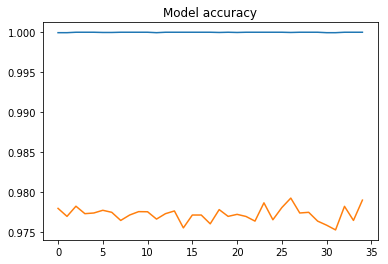

In [7]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

model.save('clement_fang_Xception.h5')
res = model.predict(X_test).argmax(axis=1)
confu = confusion_matrix(Y_cat.argmax(axis=1), res)
print ("score: ", compute_score(res, Y_test))
types = ['containership', 'cruiser', 'destroyer','coastguard', 'smallfish', 'methanier', 'cv', 'corvette', 'submarine', 'tug']
pd.DataFrame({types[i][:3]:confu[:,i] for i in range(len(types))}, index=types)

score:  0.97165991902834


,con,cru,des,coa,sma,met,cv,cor,sub,tug
containership,273,0,0,0,0,3,0,0,0,0
cruiser,0,258,0,0,1,0,0,0,0,0
destroyer,0,0,275,2,0,0,4,3,0,0
coastguard,0,1,1,140,3,0,0,2,0,2
smallfish,0,0,0,1,126,0,0,1,0,2
methanier,1,0,0,0,2,161,0,0,0,0
cv,0,0,0,1,1,0,82,2,0,0
corvette,0,0,8,2,0,0,0,128,0,0
submarine,0,0,1,0,0,0,0,1,100,1
tug,0,0,0,2,1,0,0,0,0,137


<a href="network.hdf5">link</a>